In [9]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mean_squared_error, r2_score, f1_score, recall_score, precision_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import category_encoders as ce
import warnings
import statsmodels.api as sm
from itertools import combinations
import random
from sklearn.exceptions import ConvergenceWarning


The next part was too complex to run on our simple computers and we went to the lab to run us. We were not given much time in the lab, so we ran this part only in a separate notebook. Please turn to the other notebook.

# Import the data

In [10]:
file_path = "/Users/tomsaacks/Desktop/שנה ב/סמסטר ב/פרויקט מבוסס אנליטיקה/step4/DATA/data.csv"
Data_Regression = pd.read_csv(file_path)
Data_Regression.drop(['id','term','int_rate','issue_d','yield_yearly_1','is_default?',"yield_over"], axis=1, inplace=True)

In [11]:
Data_Regression['fico_mean']=(Data_Regression['fico_range_high']+Data_Regression['fico_range_low'])/2
Data_Regression.drop(['fico_range_high','fico_range_low'], axis=1, inplace=True)

In [12]:
# Replace infinite values with NaN
Data_Regression.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
Data_Regression.dropna(inplace=True)

# Check if any infinite values remain
any_inf = Data_Regression.isin([np.inf, -np.inf]).any().any()
print(any_inf)

False


In [13]:
#splitting the data into train and test datasets, when 80% for train and 20% for test dataset + another splitting 
#for the fine tuning step (later on)
y = Data_Regression["yield_2"]  # target variable
X = Data_Regression.drop("yield_2", axis=1)


In [15]:
# Splitting the data into train and test datasets, with 80% for train and 20% for the test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


scaler_robust = RobustScaler()
X_train_scaled = scaler_robust.fit_transform(X_train)
X_test_scaled = scaler_robust.transform(X_test)




# best model from last time

          Model_Name       MSE  R2_Score
0  Linear Regression  0.007097  0.023497


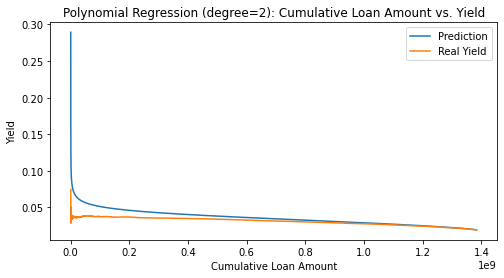

                         Model_Name       MSE  R2_Score
0  Polynomial Regression (degree=2)  0.007063  0.027427


In [7]:

# Assuming the necessary data is already loaded and split into X_train, X_test, y_train, y_test

def cross_validate_linear_regression(X, y, cv=10):
    """
    Perform cross-validation on Linear Regression using negative mean squared error (MSE) as the scoring metric.

    Args:
        X (pandas.DataFrame): The input feature data.
        y (pandas.Series): The target variable.
        cv (int, optional): The number of cross-validation folds. Defaults to 10.

    Returns:
        pandas.DataFrame: The model performance metrics for each fold.

    """
    LR = LinearRegression()
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    mse_scores = cross_val_score(LR, X, y, scoring='neg_mean_squared_error', cv=kf)
    r2_scores = cross_val_score(LR, X, y, scoring='r2', cv=kf)

    mse_scores = -mse_scores
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)

    Model_perf = pd.DataFrame(columns=['Model_Name','MSE','R2_Score'])
    Model_perf.loc[len(Model_perf)] = ['Linear Regression', avg_mse, avg_r2]

    return Model_perf

def perform_polynomial_regression(X_train, X_test, y_train, y_test):
    """
    Perform polynomial regression with degree 2 and evaluate the model performance.

    Args:
        X_train (pandas.DataFrame): The input training feature data.
        X_test (pandas.DataFrame): The input test feature data.
        y_train (pandas.Series): The training target variable.
        y_test (pandas.Series): The test target variable.

    Returns:
        pandas.DataFrame: The model performance metrics.

    """
    Model_perf = pd.DataFrame(columns=['Model_Name', 'MSE', 'R2_Score'])

    # Create a PolynomialFeatures object with degree 2
    poly = PolynomialFeatures(degree=2)

    # Transform the features into polynomial features
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Fit the polynomial regression model
    poly_LR = LinearRegression()
    poly_LR.fit(X_train_poly, y_train)

    # Get the predictions for the test data
    y_pred_poly = poly_LR.predict(X_test_poly)

    # Calculate the MSE and R2 score
    poly_mse = mean_squared_error(y_test, y_pred_poly)
    poly_r2 = r2_score(y_test, y_pred_poly)

    # Append the results to the DataFrame
    Model_perf.loc[len(Model_perf)] = ['Polynomial Regression (degree=2)', poly_mse, poly_r2]

    # Create a DataFrame for the predictions
    poly_predictions_df = pd.DataFrame(y_pred_poly, columns=['Prediction'], index=X_test.index)

    # Concatenate the predictions with the test data
    poly_result_df = pd.concat([X_test, poly_predictions_df, y_test], axis=1)

    # Plot the cumulative loan amount vs. yield for the polynomial regression model
    poly_result_df = poly_result_df.sort_values(by='Prediction', ascending=False)
    cumulative_loan_amnt = poly_result_df['loan_amnt'].cumsum()
    weighted_yield_yearly_1 = (poly_result_df['yield_2'] * poly_result_df['loan_amnt']).cumsum() / cumulative_loan_amnt
    weighted_yield = (poly_result_df['Prediction'] * poly_result_df['loan_amnt']).cumsum() / cumulative_loan_amnt

    plt.figure(figsize=(8, 4))
    plt.plot(cumulative_loan_amnt, weighted_yield, label='Prediction')
    plt.plot(cumulative_loan_amnt, weighted_yield_yearly_1, label='Real Yield')
    plt.xlabel('Cumulative Loan Amount')
    plt.ylabel('Yield')
    plt.title('Polynomial Regression (degree=2): Cumulative Loan Amount vs. Yield')
    plt.legend()
    plt.show()

    return Model_perf

# Cross-validation for Linear Regression
model_performance = cross_validate_linear_regression(X_train, y_train)
print(model_performance)

# Perform polynomial regression for degree 2
poly_model_performance = perform_polynomial_regression(X_train, X_test, y_train, y_test)
print(poly_model_performance)


In [ ]:
# Splitting the data into train and test datasets, with 80% for train and 20% for the test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


scaler_robust = RobustScaler()
X_train_scaled = scaler_robust.fit_transform(X_train)
X_test_scaled = scaler_robust.transform(X_test)

In [21]:
def forward_selection(data, target, model,improvement_threshold=0.0001):
    initial_features = list(range(data.shape[1]))
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_mse = np.inf
        for new_column in remaining_features:
            model.fit(data[:, best_features+[new_column]], target)
            y_pred = model.predict(data[:, best_features+[new_column]])
            mse = mean_squared_error(target, y_pred)
            if mse < new_mse:
                if len(best_features) >= 30:
                    return best_features
                new_mse = mse
                best_column = new_column
        best_features.append(best_column)
        print('Best MSE: ', new_mse, '\tAdded feature: ', best_column)
        if np.isinf(new_mse):
            return best_features
    return best_features

model = LinearRegression()
data_best_features = forward_selection(X_train_scaled, y_train, model,improvement_threshold=0.0001)


Best MSE:  0.007219666418345781 	Added feature:  19
Best MSE:  0.007198053809248939 	Added feature:  57
Best MSE:  0.007176307786516389 	Added feature:  0
Best MSE:  0.0071554055024496575 	Added feature:  66
Best MSE:  0.007146646465775834 	Added feature:  54
Best MSE:  0.007139501388574526 	Added feature:  60
Best MSE:  0.007132757794811731 	Added feature:  36
Best MSE:  0.007128808897712219 	Added feature:  2
Best MSE:  0.007125200023792009 	Added feature:  21
Best MSE:  0.007122241448225023 	Added feature:  41
Best MSE:  0.007118525935979718 	Added feature:  37
Best MSE:  0.007116195911847807 	Added feature:  17
Best MSE:  0.0071141841727651025 	Added feature:  26
Best MSE:  0.00711164522492613 	Added feature:  32
Best MSE:  0.007109763358626585 	Added feature:  59
Best MSE:  0.007108176629997064 	Added feature:  3
Best MSE:  0.007106860227743281 	Added feature:  40
Best MSE:  0.007105716244787283 	Added feature:  13
Best MSE:  0.007104496681873967 	Added feature:  33
Best MSE:  0.0

In [28]:
data_best_features_names = X.columns[data_best_features]
X_train_best_features = X[data_best_features_names]


In [29]:
# Splitting the data into train and test datasets, with 80% for train and 20% for the test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


scaler_robust = RobustScaler()
bX_train_scaled = scaler_robust.fit_transform(X_train)
X_test_scaled = scaler_robust.transform(X_test)

In [76]:

def perform_polynomial_regression(X_train, X_test, y_train, y_test, degrees):
    """
    Perform polynomial regression for different degrees and evaluate the model performance with Ridge and Lasso regularization.
    Find the best alpha for each regularization technique.

    Args:
        X_train (pandas.DataFrame): The input training feature data.
        X_test (pandas.DataFrame): The input test feature data.
        y_train (pandas.Series): The training target variable.
        y_test (pandas.Series): The test target variable.
        degrees (list): List of degrees for polynomial regression.

    Returns:
        pandas.DataFrame: The model performance metrics for each polynomial degree and regularization technique.

    """
    Model_perf = pd.DataFrame(columns=['Model_Name', 'MSE', 'R2_Score', 'Regularization', 'Alpha'])

    for degree in degrees:
        # Create a PolynomialFeatures object with the specified degree
        poly = PolynomialFeatures(degree=degree)
        
        # Transform the features into polynomial features
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Ridge regularization
        ridge = Ridge()
        ridge_param_grid = {'alpha': [ 0.01, 0.1, 1, 10]}  # Define the alpha values to be tested
        ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, scoring='neg_mean_squared_error', cv=5)
        ridge_grid_search.fit(X_train_poly, y_train)

        ridge_best_alpha = ridge_grid_search.best_params_['alpha']
        ridge_best_model = ridge_grid_search.best_estimator_
        y_pred_ridge = ridge_best_model.predict(X_test_poly)
        ridge_mse = mean_squared_error(y_test, y_pred_ridge)
        ridge_r2 = r2_score(y_test, y_pred_ridge)
        Model_perf.loc[len(Model_perf)] = [f'Polynomial Regression (degree={degree})', ridge_mse, ridge_r2,
                                           'Ridge', ridge_best_alpha]

        # Lasso regularization
        lasso = Lasso()
        lasso_param_grid = {'alpha': [ 0.01, 0.1, 1, 10]}  # Define the alpha values to be tested
        lasso_grid_search = GridSearchCV(lasso, lasso_param_grid, scoring='neg_mean_squared_error', cv=5)
        lasso_grid_search.fit(X_train_poly, y_train)

        lasso_best_alpha = lasso_grid_search.best_params_['alpha']
        lasso_best_model = lasso_grid_search.best_estimator_
        y_pred_lasso = lasso_best_model.predict(X_test_poly)
        lasso_mse = mean_squared_error(y_test, y_pred_lasso)
        lasso_r2 = r2_score(y_test, y_pred_lasso)
        Model_perf.loc[len(Model_perf)] = [f'Polynomial Regression (degree={degree})', lasso_mse, lasso_r2,
                                           'Lasso', lasso_best_alpha]

    return Model_perf

# Perform polynomial regression for different degrees and evaluate with Ridge and Lasso regularization
degrees = [2]
poly_model_performance = perform_polynomial_regression(X_train, X_test, y_train, y_test, degrees)


In [77]:
print(poly_model_performance)

                         Model_Name  MSE  R2_Score Regularization  Alpha
0  Polynomial Regression (degree=2) 0.01     -0.01          Ridge     10
1  Polynomial Regression (degree=2) 0.01     -0.00          Lasso     10


In [78]:


def perform_polynomial_regression(X_train, X_test, y_train, y_test, degrees):
    """
    Perform polynomial regression for different degrees and evaluate the model performance with Ridge and Lasso regularization.
    Find the best alpha for each regularization technique.

    Args:
        X_train (pandas.DataFrame): The input training feature data.
        X_test (pandas.DataFrame): The input test feature data.
        y_train (pandas.Series): The training target variable.
        y_test (pandas.Series): The test target variable.
        degrees (list): List of degrees for polynomial regression.

    Returns:
        pandas.DataFrame: The model performance metrics for each polynomial degree and regularization technique.

    """
    Model_perf = pd.DataFrame(columns=['Model_Name', 'MSE', 'R2_Score', 'Regularization', 'Alpha'])

    for degree in degrees:
        # Create a PolynomialFeatures object with the specified degree
        poly = PolynomialFeatures(degree=degree)
        
        # Transform the features into polynomial features
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Ridge regularization
        ridge = Ridge()
        ridge_param_grid = {'alpha': [ 0.01, 0.1, 1, 10]}  # Define the alpha values to be tested
        ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, scoring='neg_mean_squared_error', cv=5)
        ridge_grid_search.fit(X_train_poly, y_train)

        ridge_best_alpha = ridge_grid_search.best_params_['alpha']
        ridge_best_model = ridge_grid_search.best_estimator_
        y_pred_ridge = ridge_best_model.predict(X_test_poly)
        ridge_mse = mean_squared_error(y_test, y_pred_ridge)
        ridge_r2 = r2_score(y_test, y_pred_ridge)
        Model_perf.loc[len(Model_perf)] = [f'Polynomial Regression (degree={degree})', ridge_mse, ridge_r2,
                                           'Ridge', ridge_best_alpha]

        # Lasso regularization
        lasso = Lasso()
        lasso_param_grid = {'alpha': [ 0.01, 0.1, 1, 10]}  # Define the alpha values to be tested
        lasso_grid_search = GridSearchCV(lasso, lasso_param_grid, scoring='neg_mean_squared_error', cv=5)
        lasso_grid_search.fit(X_train_poly, y_train)

        lasso_best_alpha = lasso_grid_search.best_params_['alpha']
        lasso_best_model = lasso_grid_search.best_estimator_
        y_pred_lasso = lasso_best_model.predict(X_test_poly)
        lasso_mse = mean_squared_error(y_test, y_pred_lasso)
        lasso_r2 = r2_score(y_test, y_pred_lasso)
        Model_perf.loc[len(Model_perf)] = [f'Polynomial Regression (degree={degree})', lasso_mse, lasso_r2,
                                           'Lasso', lasso_best_alpha]

    return Model_perf

# Perform polynomial regression for different degrees and evaluate with Ridge and Lasso regularization
degrees = [2]
poly_model_performance = perform_polynomial_regression(X_train, X_test, y_train, y_test, degrees)
print(poly_model_performance)


In [79]:
print(poly_model_performance)


                         Model_Name  MSE  R2_Score Regularization  Alpha
0  Polynomial Regression (degree=2) 0.01     -0.01          Ridge     10
1  Polynomial Regression (degree=2) 0.01     -0.00          Lasso     10


In [80]:
k = 10  # define the number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# Polynomial transformation
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Lasso Regression
lasso = Lasso(alpha=0.01)

# Cross-validation
mse_scores = cross_val_score(lasso, X_train_poly, y_train, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(lasso, X_train_poly, y_train, scoring='r2', cv=kf)

mse_scores = -mse_scores

avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

# Updating model performance
Model_perf.loc[len(Model_perf)] = ['Polynomial Regression (degree=2) - Lasso alpha=0.01', avg_mse, avg_r2]
print(Model_perf)

# Fit the model to the training data
lasso.fit(X_train_poly, y_train)

# Get the predictions for the test data
predictions = lasso.predict(X_test_poly)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions, columns=['Prediction'], index=X_test.index)

# Concatenate the predictions with the test data
result_df = pd.concat([X_test, predictions_df, y_test], axis=1)

result_df = result_df.sort_values(by='Prediction', ascending=False)

# Calculate the cumulative sum of 'loan_amnt'
result_df['cumulative_loan_amnt'] = result_df['loan_amnt'].cumsum()

# Calculate the weighted yield using 'theyield_yearly_1'
result_df['weighted_yield_yearly_1'] = (result_df['yield_2'] * result_df['loan_amnt']).cumsum() / result_df['cumulative_loan_amnt']

# Calculate the weighted yield: multiply 'Prediction' by 'loan_amnt' and divide by the total 'loan_amnt'
result_df['weighted_yield'] = (result_df['Prediction'] * result_df['loan_amnt']).cumsum() / result_df['cumulative_loan_amnt']

# Create a plot
plt.figure(figsize=(10,6))

# Plot the weighted yield using 'Prediction'
plt.plot(result_df['cumulative_loan_amnt'], result_df['weighted_yield'], label='Prediction')



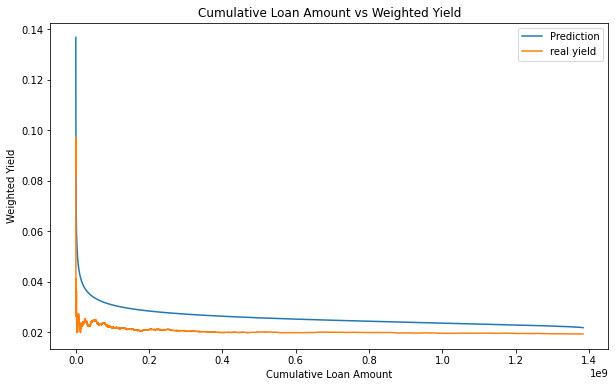

        Prediction  yield_2  diff
191644        0.14     0.08  0.05
174483        0.11     0.13 -0.02
179231        0.10     0.05  0.05
304013        0.09     0.11 -0.02
35611         0.09     0.07  0.02
...            ...      ...   ...
38957        -0.03    -0.03 -0.00
147454       -0.04     0.02 -0.06
44441        -0.04     0.07 -0.10
124246       -0.04     0.07 -0.12
232569       -0.05    -0.33  0.28

[97170 rows x 3 columns]


In [81]:
# Create a plot
plt.figure(figsize=(10,6))

# Plot the weighted yield using 'Prediction'
plt.plot(result_df['cumulative_loan_amnt'], result_df['weighted_yield'], label='Prediction')

# Plot the weighted yield using 'theyield_yearly_1'
plt.plot(result_df['cumulative_loan_amnt'], result_df['weighted_yield_yearly_1'], label='real yield')

plt.xlabel('Cumulative Loan Amount')
plt.ylabel('Weighted Yield')
plt.title('Cumulative Loan Amount vs Weighted Yield')
plt.legend()

plt.show()

# Print table with predictions, actual target and differences
result_df['diff'] = result_df['Prediction'] - result_df['yield_2']
print(result_df[['Prediction', 'yield_2', 'diff']])


Mean of 'diff': -1.8535593212225408e-06
Standard Deviation of 'diff': 0.08528777623813089


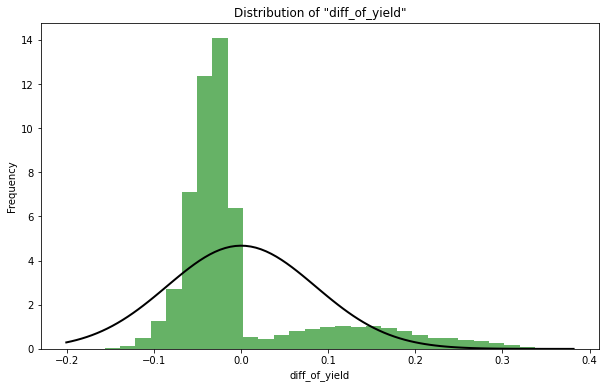

Descriptive Statistics:
count   97170.00
mean       -0.00
std         0.09
min        -0.17
25%        -0.05
50%        -0.03
75%        -0.01
max         0.36
Name: diff, dtype: float64


In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard deviation
mean_diff = result_df['diff'].mean()
std_diff = result_df['diff'].std()

print(f"Mean of 'diff': {mean_diff}")
print(f"Standard Deviation of 'diff': {std_diff}")

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(result_df['diff'], bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_diff, std_diff)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Distribution of "diff_of_yield"')
plt.xlabel('diff_of_yield')
plt.ylabel('Frequency')
plt.show()

# Print the descriptive statistics
print("Descriptive Statistics:")
print(result_df['diff'].describe())


In [40]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [42]:
# Print table with predictions, actual target and differences
result_df['diff_weighted'] = result_df['weighted_yield'] - result_df['weighted_yield_yearly_1']

Mean of 'diff_weighted': 0.0054587335295935
Standard Deviation of 'diff_weighted': 0.0026440640031357757


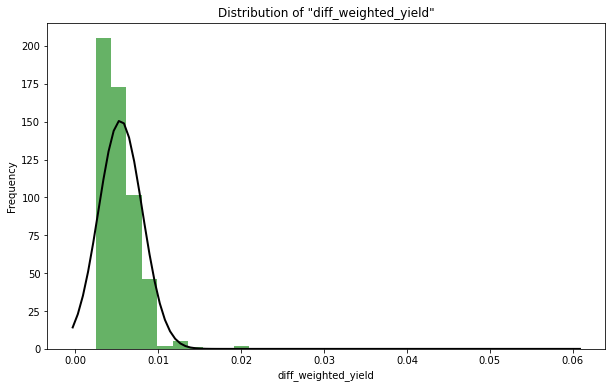

Descriptive Statistics:
count   97170.00
mean       -0.00
std         0.09
min        -0.17
25%        -0.05
50%        -0.03
75%        -0.01
max         0.36
Name: diff, dtype: float64


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard deviation
mean_diff = result_df['diff_weighted'].mean()
std_diff = result_df['diff_weighted'].std()

print(f"Mean of 'diff_weighted': {mean_diff}")
print(f"Standard Deviation of 'diff_weighted': {std_diff}")

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(result_df['diff_weighted'], bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_diff, std_diff)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Distribution of "diff_weighted_yield"')
plt.xlabel('diff_weighted_yield')
plt.ylabel('Frequency')
plt.show()

# Print the descriptive statistics
print("Descriptive Statistics:")
print(result_df['diff'].describe())


In [49]:
len(result_df)

97170

In [50]:
# Sort the dataframe
result_df = result_df.sort_values(by='cumulative_loan_amnt')

# Create bins
result_df['bins'] = pd.cut(result_df['cumulative_loan_amnt'], bins=5)

# Group by bins and calculate the mean
grouped_df = result_df.groupby('bins')[['cumulative_loan_amnt', 'weighted_yield', 'weighted_yield_yearly_1']].mean()

print(grouped_df)


                              cumulative_loan_amnt  weighted_yield   
bins                                                                 
(-1348433.925, 276721785.0]           146188069.88            0.03  \
(276721785.0, 553408570.0]            415714942.97            0.03   
(553408570.0, 830095355.0]            691539810.73            0.02   
(830095355.0, 1106782140.0]           966696033.49            0.02   
(1106782140.0, 1383468925.0]         1240619382.13            0.02   

                              weighted_yield_yearly_1  
bins                                                   
(-1348433.925, 276721785.0]                      0.02  
(276721785.0, 553408570.0]                       0.02  
(553408570.0, 830095355.0]                       0.02  
(830095355.0, 1106782140.0]                      0.02  
(1106782140.0, 1383468925.0]                     0.02  


In [55]:
print(result_df_5_parts[['cumulative_loan_amnt', 'weighted_yield', 'weighted_yield_yearly_1']][::2])


        cumulative_loan_amnt  weighted_yield  weighted_yield_yearly_1
191644              35000.00            0.14                     0.08
193227          295856050.00            0.03                     0.02
182226          554453875.00            0.03                     0.02
89489           811626650.00            0.02                     0.02
180550         1081071725.00            0.02                     0.02


In [58]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

def analyze_yield_difference(result_df):
    """
    Analyze the difference in yield predictions and provide descriptive statistics, a distribution plot, and statistical measures.

    Args:
        result_df (pandas.DataFrame): DataFrame containing the yield predictions, actual target values, and differences.

    Returns:
        None
    """

    # Calculate mean and standard deviation of the difference
    mean_diff = result_df['diff'].mean()
    std_diff = result_df['diff'].std()

    # Print mean and standard deviation
    print(f"Mean of 'diff': {mean_diff}")
    print(f"Standard Deviation of 'diff': {std_diff}")

    # Plot the distribution
    plt.figure(figsize=(10,6))
    plt.hist(result_df['diff'], bins=30, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean_diff, std_diff)
    plt.plot(x, p, 'k', linewidth=2)

    plt.title('Distribution of "diff_of_yield"')
    plt.xlabel('diff_of_yield')
    plt.ylabel('Frequency')
    plt.show()

    # Print descriptive statistics
    print("Descriptive Statistics:")
    print(result_df['diff'].describe())
analyze_yield_difference(result_df)

Mean of 'diff': -1.8535593212225408e-06
Standard Deviation of 'diff': 0.08528777623813089


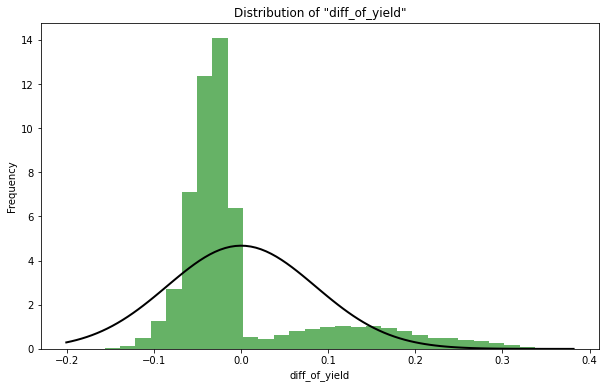

Descriptive Statistics:
count   97170.00
mean       -0.00
std         0.09
min        -0.17
25%        -0.05
50%        -0.03
75%        -0.01
max         0.36
Name: diff, dtype: float64


In [59]:
analyze_yield_difference(result_df)

Mean of 'diff_weighted': 0.0054587335295935
Standard Deviation of 'diff_weighted': 0.0026440640031357757


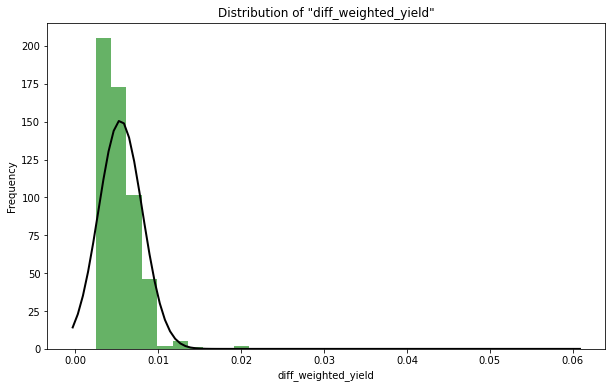

Descriptive Statistics:
count   97170.00
mean        0.01
std         0.00
min         0.00
25%         0.00
50%         0.00
75%         0.01
max         0.06
Name: diff_weighted, dtype: float64


In [61]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

def analyze_weighted_yield_difference(result_df):
    """
    Analyze the difference in weighted yield predictions and provide descriptive statistics, a distribution plot, and statistical measures.

    Args:
        result_df (pandas.DataFrame): DataFrame containing the weighted yield predictions, actual target values, and differences.

    Returns:
        None
    """

    # Calculate mean and standard deviation of the weighted yield difference
    mean_diff = result_df['diff_weighted'].mean()
    std_diff = result_df['diff_weighted'].std()

    # Print mean and standard deviation
    print(f"Mean of 'diff_weighted': {mean_diff}")
    print(f"Standard Deviation of 'diff_weighted': {std_diff}")

    # Plot the distribution
    plt.figure(figsize=(10,6))
    plt.hist(result_df['diff_weighted'], bins=30, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean_diff, std_diff)
    plt.plot(x, p, 'k', linewidth=2)

    plt.title('Distribution of "diff_weighted_yield"')
    plt.xlabel('diff_weighted_yield')
    plt.ylabel('Frequency')
    plt.show()

    # Print descriptive statistics
    print("Descriptive Statistics:")
    print(result_df['diff_weighted'].describe())

analyze_weighted_yield_difference(result_df)


In [71]:
# Sort the dataframe
result_df = result_df.sort_values(by='cumulative_loan_amnt')

# Get the number of rows in each part
n = len(result_df) // 5

# Get the first and last row from each part
rows = [result_df.iloc[i * n: (i + 1) * n].iloc[[0, -1]] for i in range(5)]

# Concatenate the dataframes
result_df_5_parts = pd.concat(rows)

# Rename columns
result_df_5_parts = result_df_5_parts.rename(columns={'cumulative_loan_amnt': 'Cumulative Loan Amount',
                                                      'weighted_yield': 'predicted_weighted_yield',
                                                      'weighted_yield_yearly_1': 'real_weighted_yield',
                                                      'diff_weighted': 'Difference in Weighted Yield'})

# Print every alternate row with selected columns
final_result_df_5_parts = result_df_5_parts[['Cumulative Loan Amount',
                                             'predicted_weighted_yield',
                                             'real_weighted_yield',
                                             'Difference in Weighted Yield']][::2]
print(final_result_df_5_parts)


        Cumulative Loan Amount  predicted_weighted_yield  real_weighted_yield   
191644                35000.00                      0.14                 0.08  \
193227            295856050.00                      0.03                 0.02   
182226            554453875.00                      0.03                 0.02   
89489             811626650.00                      0.02                 0.02   
180550           1081071725.00                      0.02                 0.02   

        Difference in Weighted Yield  
191644                          0.05  
193227                          0.01  
182226                          0.01  
89489                           0.00  
180550                          0.00  
